In [2]:
from functools import partial
from pathlib import Path
import sys
import pickle
import numpy as np
import pandas as pd

from numpy.typing import NDArray
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import seaborn as sns



In [8]:
# sergio's peak selector
def process_cycles(df):
    df = df[-0.75 < df["V"]]
    df = df[df["V"] < 0.75]

    df["c"] = df["c"].astype(int)
    # Get Red Ox
    (_, reduction), (_, oxidation) = df.groupby(np.diff(df["V"].array, append=0) > 0)

    fp_cfg = partial(
        find_peaks
        , width=10
        , distance=10
        , rel_height=0.9
    )

    oxi_peaks = map(
        lambda xs: xs[1][["V", "I"]].iloc[fp_cfg(xs[1]["I"])[0]]
        , oxidation.groupby("c")
    )
    red_peaks = map(
        lambda xs: xs[1][["V", "I"]].iloc[fp_cfg(-xs[1]["I"])[0]]
        , reduction.groupby("c")
    )
    return tuple(oxi_peaks), tuple(red_peaks)

In [2]:
def get_traces_min(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = df.loc[:, 'obj'].to_numpy()
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
    return np.array(traces_min)

def get_traces_max(data, replace_nan=True):
    traces_max = []
    for df in data:
        trace = df.loc[:, 'obj'].to_numpy()
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_max = [np.nanmax(trace[:i+1]) for i in range(len(trace))]
        traces_max.append(trace_max)
    return np.array(traces_max)

def plot_min_trace_mean(
    data, ax=None, color=None, label=None, categorical=False, stde=False, unc=True, shift=0.0, maximize=False,
    linewidth=4, 
):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    
    if not maximize:
        if categorical is True:
            traces_min = get_traces_min_for_categorical(data) - shift
        else:
            traces_min = get_traces_min(data) - shift
    else:
        traces_min = get_traces_max(data)-shift
    
    mean = np.nanmean(traces_min, axis=0)
    if stde is True:
        # standard error
        stde = np.nanstd(traces_min, axis=0, ddof=1) / np.sqrt(np.shape(traces_min)[0] - 1)
    else:
        # standard deviation
        stde = np.nanstd(traces_min, axis=0, ddof=1)
        
    x = range(1, np.shape(traces_min)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=linewidth+1)
    plot_ = ax.plot(x, mean, color=color, linewidth=linewidth, label=label)
    
    if unc is True:
        ax.fill_between(x, y1=mean - 1.96*stde, y2=mean + 1.96*stde, alpha=0.2, color=color)
        ax.plot(x, mean - 1.96*stde, color=color, linewidth=1, alpha=0.5)
        ax.plot(x, mean + 1.96*stde, color=color, linewidth=1, alpha=0.5)
        
    return plot_

In [3]:
res = pickle.load(open('jul4_echem/30.pkl', 'rb'))
print(res.param_space)
params = res.observations.get_params()
values = res.observations.get_values()

param_names = [p.name for p in res.param_space]

df = pd.DataFrame({
    'ligand_identity': params[:,0].astype(str),
    'Metal_identity': params[:,1].astype(str),
    'number_mixings': params[:,2].astype(float),
    'ligand/metal ratio': params[:, 2].astype(float),
    'obj': values.astype(float),
})
df.head()

Categorical (name='ligand_identity', num_opts: 3, options=['H20', 'Pyridine', 'Ethylene Diamine'], descriptors=[])
Categorical (name='Metal_identity', num_opts: 2, options=['Silver (I)', 'Copper (II)'], descriptors=[])
Discrete (name='number_mixings', low=0.0, high=1.0, stride=0.1, options=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
Continuous (name='ligand/metal ratio', low=1, high=9, is_periodic=False)


,ligand_identity,Metal_identity,number_mixings,ligand/metal ratio,obj
0,Pyridine,Copper (II),7.0,7.0,-0.121672
1,Pyridine,Silver (I),9.0,9.0,0.078880
2,Ethylene Diamine,Copper (II),10.0,10.0,-0.100707
3,Ethylene Diamine,Silver (I),8.0,8.0,0.004709
4,Ethylene Diamine,Copper (II),5.0,5.0,-0.089873


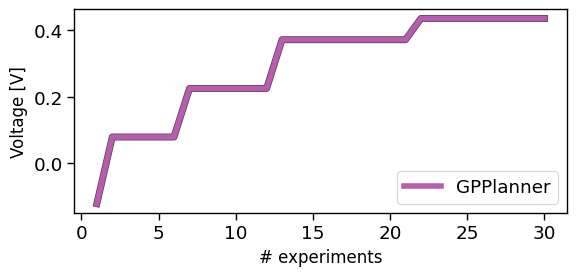

In [48]:
# optimization trace 
fig, ax = plt.subplots(1, 1, figsize=(6,3))

plot_min_trace_mean([df], ax=ax, label='GPPlanner', maximize=True, color='#b95cb0')

ax.set_xlabel('# experiments', fontsize=12)
ax.set_ylabel('Voltage [V]', fontsize=12)

ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('electrochem_atlas_trace.png', dpi=300)

In [25]:
def unpack_cv(fname):
    HEADER = ("I", "V", "R", "T", "h", "t", "c")
    results = pd.read_csv(fname, names=HEADER)
    results = results[results["c"] >= 4]
    results["I"] *= 1E6
    results['smoothed_I'] = gaussian_filter1d(results["I"], sigma=2)

    oxi_peaks, _ = process_cycles(results)
    def checknum(x):
        y = x["I"].argmax()
        if (pd.isna(y)): return -1
        return x.iloc[y]

    oxivalues = pd.concat(
        map(checknum,oxi_peaks)
        , axis=1
        , ignore_index=True
    ).T
    max_val = oxivalues.iloc[np.argmax(oxivalues["V"])]
    
    return results, max_val

In [28]:
fname1 = 'data/77adc640-1ad8-11ee-884e-d83add0cd5a8.csv'
fname2 = 'data/5300964c-1ae2-11ee-884e-d83add0cd5a8.csv'

results1, max_val1 = unpack_cv(fname1)
results2, max_val2 = unpack_cv(fname2)

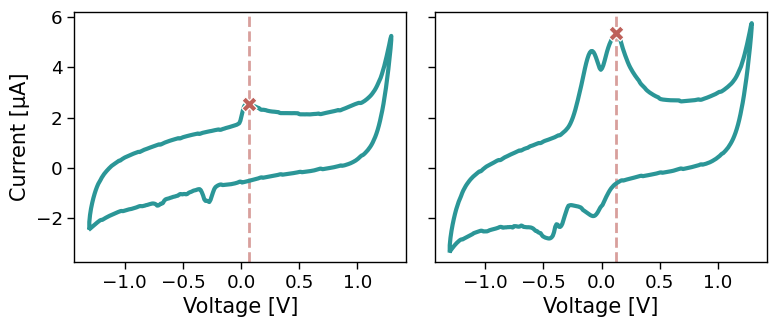

In [50]:

fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)

# plot cv #1
sns.lineplot(
        data=results1
        , x="V"
        , y="I"
        , sort=False
        , color="#2b9697"
        , ax=axes[0]
        , lw=3
)
sns.scatterplot(
    x=max_val1["V"]
    , y=[max_val1["I"]]
    , color="#be605a"
    , s=120
    , marker='X'
    , ax=axes[0]
    , zorder=3,
)
axes[0].axvline(max_val1['V'], ls='--', lw=2, alpha=0.6, c="#be605a", zorder=1)

# plot cv #2
sns.lineplot(
        data=results2
        , x="V"
        , y="I"
        , sort=False
        , color="#2b9697"
        , ax=axes[1]
        , lw=3
)
sns.scatterplot(
    x=max_val2["V"]
    , y=[max_val2["I"]]
    , color="#be605a"
    , s=120
    , marker='X'
    , ax=axes[1]
    , zorder=3,
)
axes[1].axvline(max_val2['V'], ls='--', lw=2, alpha=0.6, c="#be605a", zorder=1)

axes[0].set_xlabel("Voltage [V]", fontsize=15)
axes[1].set_xlabel("Voltage [V]", fontsize=15)
axes[0].set_ylabel("Current [μA]", fontsize=15)
axes[1].set_ylabel('')
# ax.set(ylim=[1.094+0.000650, 1.094+0.000750])
# fig.set_size_inches(2.4, 1.8)
plt.tight_layout()
plt.savefig('cv_subplots_good.png', dpi=300)

## Prepare dataset for addition to Olympus

In [10]:
res = pickle.load(open('jul4_echem/30.pkl', 'rb'))
print(res.param_space)
params = res.observations.get_params()
values = res.observations.get_values()

param_names = [p.name for p in res.param_space]

df = pd.DataFrame({
    'ligand_identity': params[:,0].astype(str),
    'Metal_identity': params[:,1].astype(str),
    'number_mixings': params[:,2].astype(float),
    'ligand/metal ratio': params[:, 3].astype(float),
    'obj': values.astype(float),
})
df.head()

Categorical (name='ligand_identity', num_opts: 3, options=['H20', 'Pyridine', 'Ethylene Diamine'], descriptors=[])
Categorical (name='Metal_identity', num_opts: 2, options=['Silver (I)', 'Copper (II)'], descriptors=[])
Discrete (name='number_mixings', low=0.0, high=1.0, stride=0.1, options=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
Continuous (name='ligand/metal ratio', low=1, high=9, is_periodic=False)


,ligand_identity,Metal_identity,number_mixings,ligand/metal ratio,obj
0,Pyridine,Copper (II),7.0,6.638719,-0.121672
1,Pyridine,Silver (I),9.0,5.066545,0.078880
2,Ethylene Diamine,Copper (II),10.0,7.427776,-0.100707
3,Ethylene Diamine,Silver (I),8.0,8.931573,0.004709
4,Ethylene Diamine,Copper (II),5.0,5.116949,-0.089873


In [13]:
df = df.replace('Ethylene Diamine', 'Ethylenediamine')
df = df.replace('Copper (II)', 'Copper(II)')
df = df.replace('Silver (I)', 'Silver(I)')

In [14]:
df

,ligand_identity,Metal_identity,number_mixings,ligand/metal ratio,obj
0,Pyridine,Copper(II),7.0,6.638719,-0.121672
1,Pyridine,Silver(I),9.0,5.066545,0.078880
2,Ethylenediamine,Copper(II),10.0,7.427776,-0.100707
3,Ethylenediamine,Silver(I),8.0,8.931573,0.004709
4,Ethylenediamine,Copper(II),5.0,5.116949,-0.089873
5,Pyridine,Silver(I),10.0,1.000000,0.004531
6,H20,Silver(I),1.0,5.057622,0.224901
7,H20,Silver(I),10.0,3.977553,0.015229
8,H20,Silver(I),10.0,8.694013,0.089580
9,Ethylenediamine,Copper(II),10.0,1.047863,-0.078910


In [15]:
df.to_csv('data.csv', index=False)